In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf




#Clean up data
df=pd.read_csv('abalone.data',names=['Sex','Length','Diameter',
                                      'Height','Whole weight','Shucked weight',
                                      'Viscera weight','Shell weight','Rings'])
df=pd.concat([pd.get_dummies(df['Sex']),df],axis=1) #one hot encode feature
del df['Sex']

#Create train, validation, test sets
X_train, X_test, y_train, y_test=train_test_split(df.values[:,:-1],df.values[:,-1],test_size=.2)
X_train, X_val, y_train, y_val=train_test_split(X_train,y_train,test_size=.25)

print "Training Set Size:",(X_train.shape)
print "Test Set Size:",(X_test.shape)

scaler=StandardScaler()
X_train[:,3:]=scaler.fit_transform(X_train[:,3:])
X_test[:,3:]=scaler.transform(X_test[:,3:])
X_val[:,3:]=scaler.transform(X_val[:,3:])

Training Set Size: (2505, 10)
Test Set Size: (836, 10)


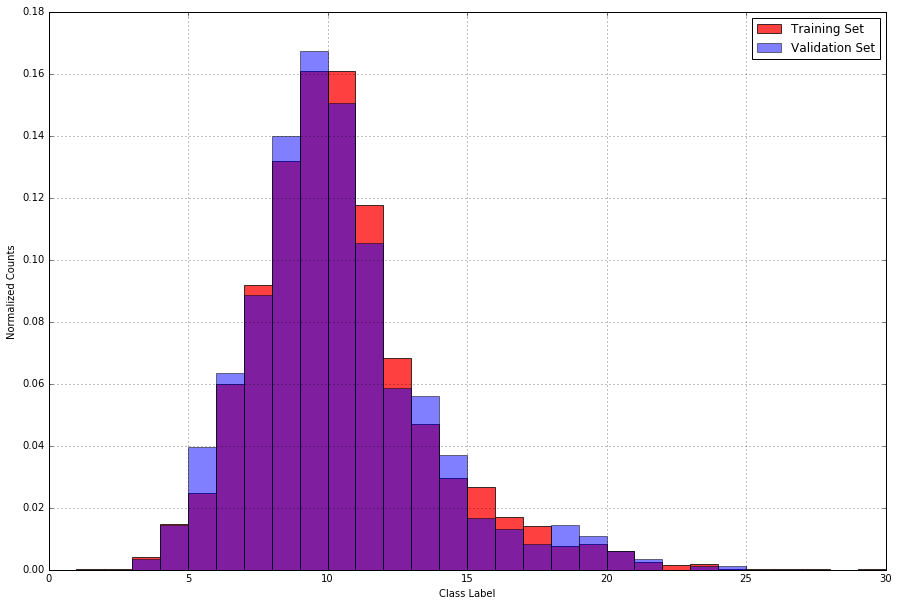

In [15]:
label_counts_train=np.bincount(y_train.astype(np.int))
label_counts_val=np.bincount(y_val.astype(np.int))

label_counts_train=label_counts_train/float(label_counts_train.sum())
label_counts_val=label_counts_val/float(label_counts_val.sum())

ind=np.arange(len(label_counts_train))
_, ax = plt.subplots(figsize=(15,10))
ax.bar(ind,label_counts_train,1, color='r',alpha=.75)
ind=np.arange(len(label_counts_val))
ax.bar(ind,label_counts_val,1, color='b',alpha=.5)
plt.legend(('Training Set','Validation Set'))
plt.xlabel('Class Label')
plt.ylabel('Normalized Counts')
plt.grid()
plt.show()

In [16]:
def one_hot_labels(y,num_labels):
    return (np.arange(num_labels)==y[:,None]).astype(np.float)


y_train=one_hot_labels(y_train-1,29)
y_test=one_hot_labels(y_test-1,29)
y_val=one_hot_labels(y_val-1,29)



In [17]:
#TODO

def xiaver_init(shape):    
    (fan_in, fan_out) = shape
    low = -4*np.sqrt(6.0/(fan_in + fan_out))
    high = 4*np.sqrt(6.0/(fan_in + fan_out))
    return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))                
                
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


In [20]:
beta=1e-6
batch_size = 100
num_hidden = 70
d=X_train.shape[1]
num_labels=29

graph = tf.Graph()
with graph.as_default():
    tf_train_x =tf.placeholder(tf.float32,shape=(batch_size, d))
    tf_train_y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_x = tf.constant(X_val.astype(np.float32))
    tf_test_x = tf.constant(X_test.astype(np.float32))
    
    W_1 = tf.Variable(tf.truncated_normal([d, num_hidden]))
    b_1 = tf.Variable(tf.zeros([num_hidden]))

    a_1=tf.matmul(tf_train_x,W_1)+b_1
    h_1=tf.nn.relu(a_1)
    
    p=tf.placeholder(tf.float32)
    h_1d=tf.nn.dropout(h_1,p)
    
    W_2 = xiaver_init((num_hidden,num_labels))
    b_2 = tf.Variable(tf.zeros([num_labels]))
    
    a_2=tf.matmul(h_1d,W_2)+b_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(a_2, tf_train_y))
    +beta*tf.reduce_sum(tf.abs(W_1))+beta*tf.n

    opt = tf.train.AdamOptimizer().minimize(loss)
    
    train_pred=tf.nn.softmax(a_2)
    val_pred= tf.nn.softmax(
        tf.matmul(tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_x, W_1) + b_1),p),W_2)+b_2)
    test_pred= tf.nn.softmax(
        tf.matmul(tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_x, W_1) + b_1),p),W_2)+b_2)
    

In [21]:
num_steps = int(1e4)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    k=0
    for step in range(1,num_steps+1):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        k+=batch_size
    
        if k > y_train.shape[0]:
        #print("Reshuffling")
            idx=np.random.permutation(y_train.shape[0])
            X_train=X_train[idx,:]
            y_train=y_train[idx]
            k=0
    
    # Generate a minibatch.
        batch_data = X_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_x : batch_data, tf_train_y : batch_labels, p:.2}
        _, l, predictions= session.run(
          [opt, loss, train_pred], feed_dict=feed_dict)
    
        if step % 1000 == 0 or step==1:
            print "Iteration %d Minibatch Loss %f Accuracy %.1f%%" %(step,l,accuracy(predictions,batch_labels))
            print "Validation Accuracy %f%%\n" % (accuracy(val_pred.eval({p:1}),y_val))
    
    #print "Test Accuracy %f%%\n" % (accuracy(test_pred.eval({p:1}),y_test)) 

Initialized
Iteration 1 Minibatch Loss 35.608452 Accuracy 6.0%
Validation Accuracy 11.363636%

Iteration 1000 Minibatch Loss 3.699441 Accuracy 14.0%
Validation Accuracy 22.129187%

Iteration 2000 Minibatch Loss 2.470782 Accuracy 21.0%
Validation Accuracy 25.000000%

Iteration 3000 Minibatch Loss 2.373599 Accuracy 19.0%
Validation Accuracy 26.674641%

Iteration 4000 Minibatch Loss 2.259701 Accuracy 18.0%
Validation Accuracy 26.674641%

Iteration 5000 Minibatch Loss 2.090834 Accuracy 27.0%
Validation Accuracy 25.837321%

Iteration 6000 Minibatch Loss 2.224057 Accuracy 17.0%
Validation Accuracy 27.153110%

Iteration 7000 Minibatch Loss 2.344597 Accuracy 20.0%
Validation Accuracy 26.555024%

Iteration 8000 Minibatch Loss 2.121606 Accuracy 23.0%
Validation Accuracy 25.717703%

Iteration 9000 Minibatch Loss 2.083227 Accuracy 17.0%
Validation Accuracy 25.239234%

Iteration 10000 Minibatch Loss 1.885052 Accuracy 32.0%
Validation Accuracy 25.717703%

